In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from itertools import permutations

def optimize_path_locally(points, chunk_size=4):
    """
    Optimize path locally by considering all permutations of chunks of size k,
    preserving first and last points of each chunk.

    Args:
        points: np.array of shape (n, 2) containing point coordinates
        chunk_size: size of chunks to consider for permutation (default 4)

    Returns:
        np.array of shape (n, 2) with optimized point ordering
    """
    if chunk_size < 3:
        return points

    n_points = len(points)
    optimized_points = points.copy()

    # Calculate chunk starts, ensuring last chunk doesn't overflow
    chunk_starts = range(0, n_points - chunk_size + 1, chunk_size - 1)

    # Track if any improvements were made
    improvement_made = True
    iteration = 0
    max_iterations = 10  # Prevent infinite loops

    while improvement_made and iteration < max_iterations:
        improvement_made = False
        iteration += 1

        for start in chunk_starts:
            # Extract current chunk
            chunk = optimized_points[start:start + chunk_size]

            # Get all valid permutations (keeping first and last fixed)
            middle_perms = list(permutations(chunk[1:-1]))
            best_length = float('inf')
            best_perm = None

            # Try each permutation
            for perm in middle_perms:
                test_chunk = np.vstack((
                    chunk[0],
                    perm,
                    chunk[-1]
                ))

                # Calculate path length for this permutation
                length = np.sum(np.sqrt(np.sum(np.diff(test_chunk, axis=0)**2, axis=1)))

                if length < best_length:
                    best_length = length
                    best_perm = test_chunk

            # Calculate current length
            current_length = np.sum(np.sqrt(np.sum(np.diff(chunk, axis=0)**2, axis=1)))

            # If we found a better permutation, use it
            if best_length < current_length - 1e-10:  # Small epsilon for floating point comparison
                optimized_points[start:start + chunk_size] = best_perm
                improvement_made = True

    return optimized_points

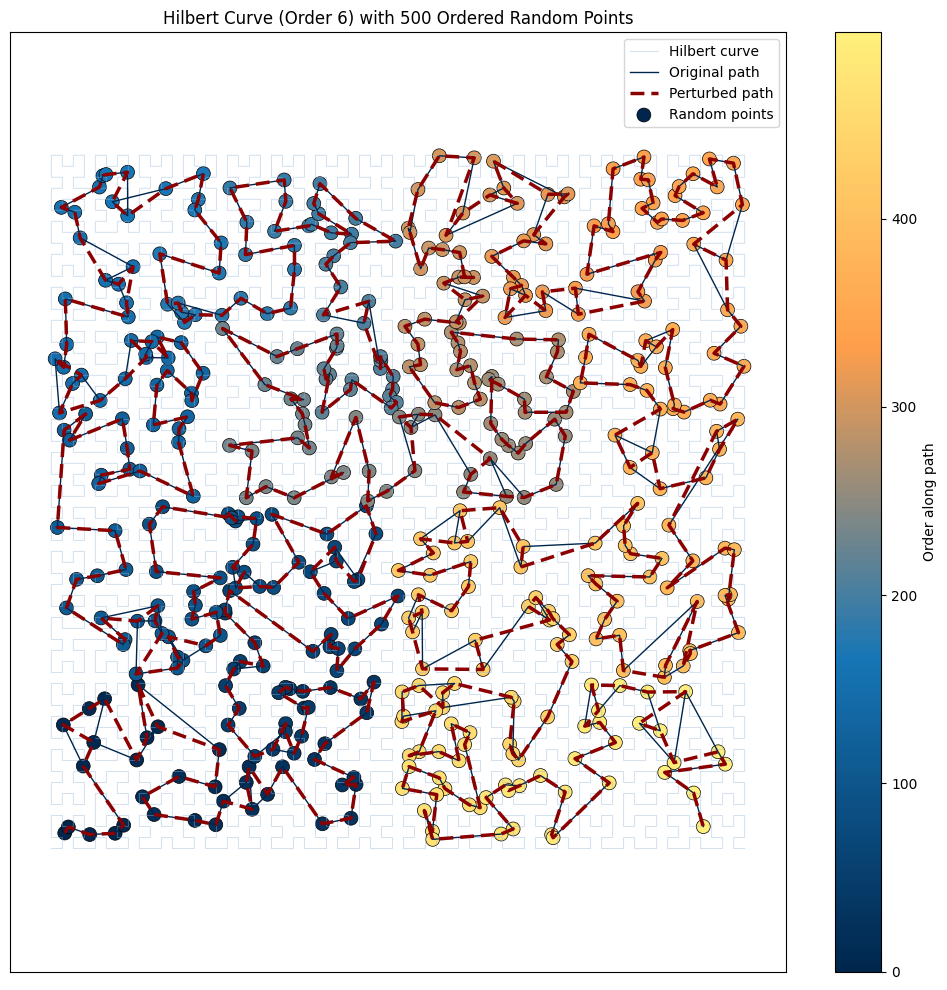

Hilbert curve length: 65.000
Random points path length: 21.927
Optimized path length: 21.059
Beta value for Hilbert curve: 0.981
Beta value for optimized Hilbert curve: 0.942
Optimization improvement: 4.0%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def d2xy(n, d):
    """Convert distance along curve to (x,y) coordinates."""
    x = y = 0
    rx = ry = 0
    s = 1
    t = d

    for i in range(n):
        rx = 1 & (t >> 1)
        ry = 1 & (t ^ rx)
        if ry == 0:
            if rx == 1:
                x = s - 1 - x
                y = s - 1 - y
            x, y = y, x
        x += s * rx
        y += s * ry
        t >>= 2
        s <<= 1

    return np.array([x, y])

def hilbert_curve(order):
    """Generate Hilbert curve points of given order."""
    n_points = 4**order
    points = np.zeros((n_points, 2), dtype=np.float64)
    for i in range(n_points):
        points[i] = d2xy(order, i)
    return points / (2**order - 1)

def order_points_by_hilbert(random_points, hilbert_points):
    """
    Order random points based on their nearest neighbors on the Hilbert curve.

    Args:
        random_points: Array of random points in unit square
        hilbert_points: Array of points along Hilbert curve
    Returns:
        ordered_points: Random points ordered by Hilbert curve proximity
    """
    # Calculate distances between random points and all Hilbert curve points
    distances = cdist(random_points, hilbert_points)

    # For each random point, find its nearest Hilbert curve point
    nearest_indices = np.argmin(distances, axis=1)

    # Sort random points based on their nearest Hilbert curve index
    ordering = np.argsort(nearest_indices)

    return random_points[ordering]

# Generate Hilbert curve
order = 6
hilbert_points = hilbert_curve(order)

# Generate random points
np.random.seed(2023)  # for reproducibility
n_random = 500
random_points = np.random.rand(n_random, 2)

# Order random points by Hilbert curve
ordered_points = order_points_by_hilbert(random_points, hilbert_points)

# Plot everything
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.subplots_adjust(top=0.95)  # Shift everything down a bit

# Get optimized path
optimized_points = optimize_path_locally(ordered_points, chunk_size=6)

# Mask Hilbert curve points outside unit square
masked_hilbert = hilbert_points.copy()
mask = (masked_hilbert[:, 0] < 0) | (masked_hilbert[:, 0] > 1) | (masked_hilbert[:, 1] < 0) | (masked_hilbert[:, 1] > 1)
masked_hilbert[mask] = np.nan

# Plot Hilbert curve - light blue with same luminance as gray(0.7)
plt.plot(masked_hilbert[:, 0], masked_hilbert[:, 1], color='#94B7DB', linewidth=0.75, alpha=0.4, label='Hilbert curve')

# Plot random points and their paths
plt.plot(ordered_points[:, 0], ordered_points[:, 1], color='#00264D', linewidth=1.0, label='Original path')
plt.plot(optimized_points[:, 0], optimized_points[:, 1], color='#8B0000', linewidth=2.5, dashes=(4, 2), label='Perturbed path')

# Create custom colormap that goes from dark blue to bright yellow
from matplotlib.colors import LinearSegmentedColormap
colors = ['#00264D', '#1776B6', '#FF9E4A', '#FFF07C']  # Dark blue to bright yellow
n_bins = 256
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Scatter plot with custom colormap
scatter = plt.scatter(ordered_points[:, 0], ordered_points[:, 1],
                     c=np.arange(len(ordered_points)),
                     cmap=custom_cmap,
                     s=100,
                     edgecolors='black',
                     linewidth=0.5,
                     label='Random points')

plt.colorbar(scatter, label='Order along path')
plt.title(f'Hilbert Curve (Order {order}) with {n_random} Ordered Random Points')
plt.axis('equal')
plt.grid(True, alpha=0.15)
plt.legend(loc='upper right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('hilbert.eps', format='eps')
plt.show()

# Print path length comparison
def path_length(points):
    return np.sum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))

hilbert_length = path_length(hilbert_points)
random_length = path_length(ordered_points)
optimized_length = path_length(optimized_points)
beta_Hilbert = random_length / np.sqrt(n_random)
beta_Hilbert_opt = optimized_length / np.sqrt(n_random)

print(f"Hilbert curve length: {hilbert_length:.3f}")
print(f"Random points path length: {random_length:.3f}")
print(f"Optimized path length: {optimized_length:.3f}")
print(f"Beta value for Hilbert curve: {beta_Hilbert:.3f}")
print(f"Beta value for optimized Hilbert curve: {beta_Hilbert_opt:.3f}")
print(f"Optimization improvement: {100*(random_length-optimized_length)/random_length:.1f}%")


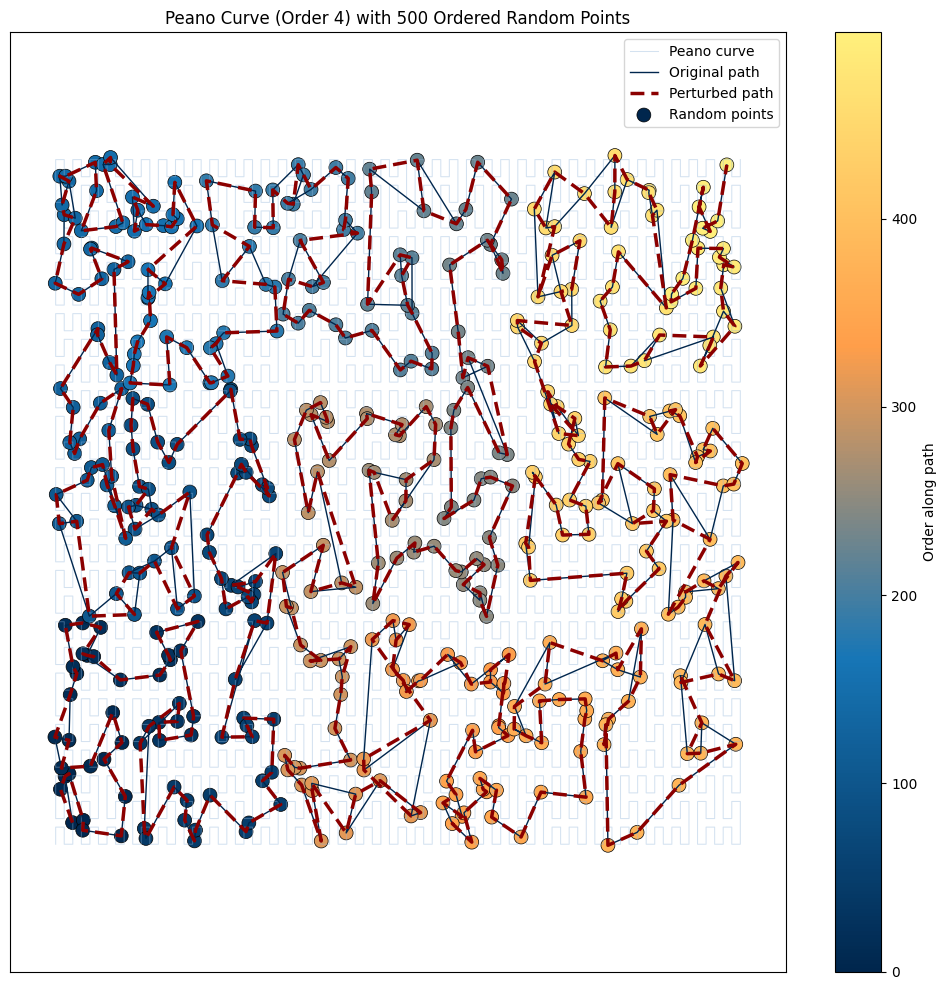

Peano curve length: 80.988
Random points path length: 23.273
Optimized path length: 21.563
Beta value for Peano curve: 1.041
Beta value for optimized Peano curve: 0.964
Optimization improvement: 7.3%


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def peano(n):
    """
    Generate points of a Peano space-filling curve.
    Direct port of the elegant MATLAB implementation.
    """
    k = 1

    if n <= 0:
        return np.array([0]), np.array([0])

    # Recursive call to get previous order
    xo, yo = peano(n-1)

    # Generate new coordinates using the pattern
    x = 1.0/3 * np.concatenate([
        -k + xo,
        xo,
        k + xo,
        k - xo,
        -xo,
        -k - xo,
        -k + xo,
        xo,
        k + xo
    ])

    y = 1.0/3 * np.concatenate([
        -k + yo,
        -k - yo,
        -k + yo,
        yo,
        -yo,
        yo,
        k + yo,
        k - yo,
        k + yo
    ])

    return x, y

def order_points_by_peano(random_points, peano_points):
    """
    Order random points based on their nearest neighbors on the Peano curve.
    """
    # Calculate distances between random points and all Peano curve points
    distances = cdist(random_points, peano_points)

    # For each random point, find its nearest Peano curve point
    nearest_indices = np.argmin(distances, axis=1)

    # Sort random points based on their nearest Peano curve index
    ordering = np.argsort(nearest_indices)

    return random_points[ordering]

# Generate Peano curve
order = 4  # Adjusted for Peano curve density
x, y = peano(order)
peano_points = np.column_stack([y, x])  # Note: x,y swapped to match unit square orientation

peano_points += [0.5, 0.5]

# Generate random points
np.random.seed(42)  # for reproducibility
n_random = 500
random_points = np.random.rand(n_random, 2)

# Order random points by Peano curve
ordered_points = order_points_by_peano(random_points, peano_points)

# Plot everything
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.subplots_adjust(top=0.95)  # This shifts everything down a bit

# Get optimized path
optimized_points = optimize_path_locally(ordered_points, chunk_size=6)

# Mask Peano curve points outside unit square
masked_peano = peano_points.copy()
mask = (masked_peano[:, 0] < 0) | (masked_peano[:, 0] > 1) | (masked_peano[:, 1] < 0) | (masked_peano[:, 1] > 1)
masked_peano[mask] = np.nan

# Plot Peano curve - light blue with same luminance as gray(0.7)
plt.plot(masked_peano[:, 0], masked_peano[:, 1], color='#94B7DB', linewidth=0.75, alpha=0.4, label='Peano curve')

# Plot random points and their paths
plt.plot(ordered_points[:, 0], ordered_points[:, 1], color='#00264D', linewidth=1.0, label='Original path')
plt.plot(optimized_points[:, 0], optimized_points[:, 1], color='#8B0000', linewidth=2.5, dashes=(4, 2), label='Perturbed path')

# Create custom colormap that goes from dark blue to bright yellow
from matplotlib.colors import LinearSegmentedColormap
colors = ['#00264D', '#1776B6', '#FF9E4A', '#FFF07C']  # Dark blue to bright yellow
n_bins = 256
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Scatter plot with custom colormap
scatter = plt.scatter(ordered_points[:, 0], ordered_points[:, 1],
                     c=np.arange(len(ordered_points)),
                     cmap=custom_cmap,
                     s=100,
                     edgecolors='black',
                     linewidth=0.5,
                     label='Random points')

plt.colorbar(scatter, label='Order along path')
plt.title(f'Peano Curve (Order {order}) with {n_random} Ordered Random Points')
plt.axis('equal')
plt.grid(True, alpha=0.15)
plt.legend(loc='upper right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('peano.eps', format='eps')
plt.show()

# Print path length comparison
def path_length(points):
    return np.sum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))

peano_length = path_length(peano_points)
random_length = path_length(ordered_points)
optimized_length = path_length(optimized_points)
beta_Peano = random_length / np.sqrt(n_random)
beta_Peano_opt = optimized_length / np.sqrt(n_random)

print(f"Peano curve length: {peano_length:.3f}")
print(f"Random points path length: {random_length:.3f}")
print(f"Optimized path length: {optimized_length:.3f}")
print(f"Beta value for Peano curve: {beta_Peano:.3f}")
print(f"Beta value for optimized Peano curve: {beta_Peano_opt:.3f}")
print(f"Optimization improvement: {100*(random_length-optimized_length)/random_length:.1f}%")

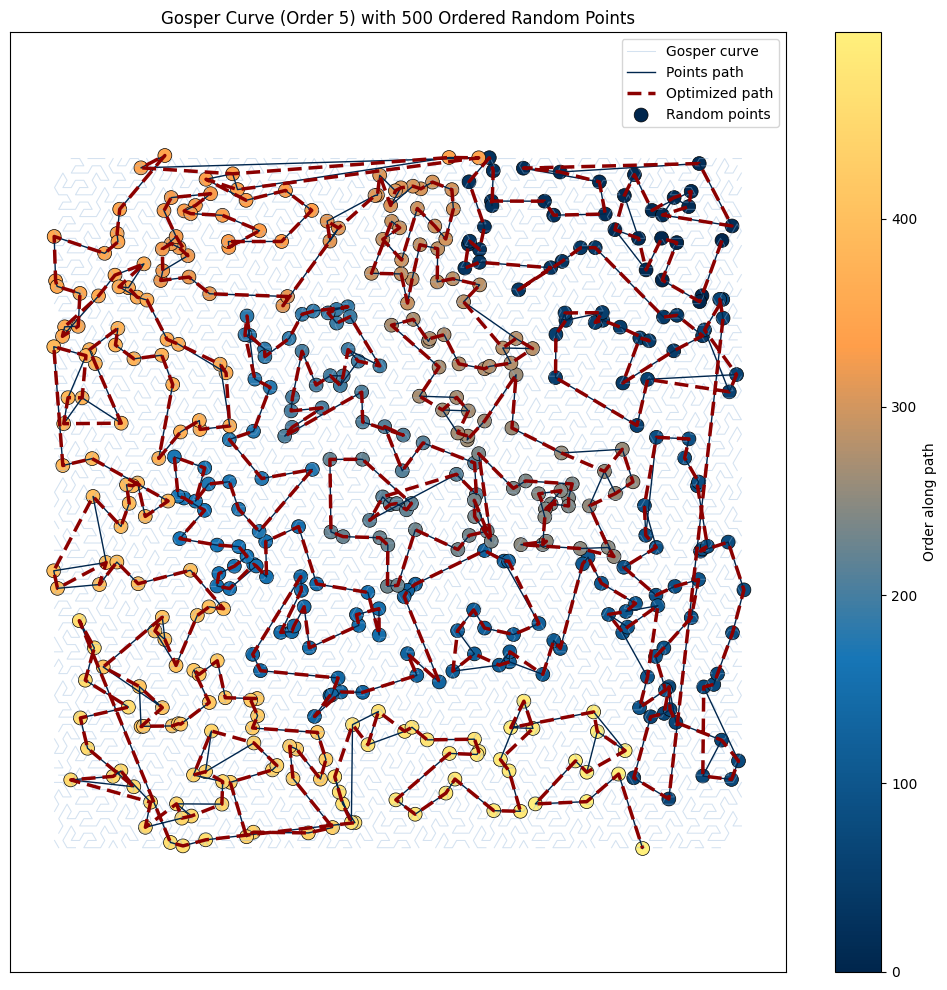

Gosper curve length: 203.097
Random points path length: 25.054
Optimized path length: 24.198
Beta value for Gosper curve: 1.120
Beta value for optimized Gosper curve: 1.082
Optimization improvement: 3.4%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def generate_gosper_sequence(n):
    """Generate L-system sequence for Gosper curve of order n."""
    rules = {
        'A': 'A-B--B+A++AA+B-',
        'B': '+A-BB--B-A++A+B'
    }
    sequence = 'A'
    for _ in range(n):
        sequence = ''.join(rules.get(c, c) for c in sequence)
    return sequence

def gosper_curve(order, step_size=1.0):
    """
    Generate points for Gosper curve of given order, scaled to contain unit square.
    """
    # Generate L-system sequence
    sequence = generate_gosper_sequence(order)

    # Initialize turtle state
    angle = 0
    x, y = 0, 0
    points = [(x, y)]

    # Process each instruction
    for instruction in sequence:
        if instruction in 'AB':
            x += step_size * np.cos(angle)
            y += step_size * np.sin(angle)
            points.append((x, y))
        elif instruction == '+':
            angle += np.pi / 3
        elif instruction == '-':
            angle -= np.pi / 3

    # Convert to numpy array
    points = np.array(points)

    # Center at origin
    points -= np.mean(points, axis=0)

    # Calculate required scaling
    current_width = points[:, 0].max() - points[:, 0].min()
    current_height = points[:, 1].max() - points[:, 1].min()

    target_size = 1.8
    scale = target_size / min(current_width, current_height)
    points *= scale

    # Center and shift
    points -= np.mean(points, axis=0)
    points += [0.5, 0.5]

    return points

def order_points_by_gosper(random_points, gosper_points):
    """
    Order random points based on their nearest neighbors on the Gosper curve.
    """
    # Calculate distances between random points and all Gosper curve points
    distances = cdist(random_points, gosper_points)

    # For each random point, find its nearest Gosper curve point
    nearest_indices = np.argmin(distances, axis=1)

    # Sort random points based on their nearest Gosper curve index
    ordering = np.argsort(nearest_indices)

    return random_points[ordering]

# Generate Gosper curve
order = 5  # Using order 5 as in the original
gosper_points = gosper_curve(order)

# Generate random points
np.random.seed(2024)  # for reproducibility
n_random = 500
random_points = np.random.rand(n_random, 2)

# Order random points by Gosper curve
ordered_points = order_points_by_gosper(random_points, gosper_points)

# Plot everything
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.subplots_adjust(top=0.95)  # This shifts everything down a bit

# Get optimized path
optimized_points = optimize_path_locally(ordered_points, chunk_size=6)

# Mask Gosper curve points outside unit square
masked_gosper = gosper_points.copy()
mask = (masked_gosper[:, 0] < 0) | (masked_gosper[:, 0] > 1) | (masked_gosper[:, 1] < 0) | (masked_gosper[:, 1] > 1)
masked_gosper[mask] = np.nan

# Plot Gosper curve - light blue with same luminance as gray(0.7)
plt.plot(masked_gosper[:, 0], masked_gosper[:, 1], color='#94B7DB', linewidth=0.75, alpha=0.4, label='Gosper curve')

# Plot random points and their paths
plt.plot(ordered_points[:, 0], ordered_points[:, 1], color='#00264D', linewidth=1.0, label='Points path')
plt.plot(optimized_points[:, 0], optimized_points[:, 1], color='#8B0000', linewidth=2.5, dashes=(4, 2), label='Optimized path')

# Create custom colormap that goes from dark blue to bright yellow
from matplotlib.colors import LinearSegmentedColormap
colors = ['#00264D', '#1776B6', '#FF9E4A', '#FFF07C']  # Dark blue to bright yellow
n_bins = 256
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Scatter plot with custom colormap
scatter = plt.scatter(ordered_points[:, 0], ordered_points[:, 1],
                     c=np.arange(len(ordered_points)),
                     cmap=custom_cmap,
                     s=100,
                     edgecolors='black',
                     linewidth=0.5,
                     label='Random points')

plt.colorbar(scatter, label='Order along path')
plt.title(f'Gosper Curve (Order {order}) with {n_random} Ordered Random Points')
plt.axis('equal')
plt.grid(True, alpha=0.15)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

# Print path length comparison
def path_length(points):
    return np.sum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))

gosper_length = path_length(gosper_points)
random_length = path_length(ordered_points)
optimized_length = path_length(optimized_points)
beta_Gosper = random_length / np.sqrt(n_random)
beta_Gosper_opt = optimized_length / np.sqrt(n_random)

print(f"Gosper curve length: {gosper_length:.3f}")
print(f"Random points path length: {random_length:.3f}")
print(f"Optimized path length: {optimized_length:.3f}")
print(f"Beta value for Gosper curve: {beta_Gosper:.3f}")
print(f"Beta value for optimized Gosper curve: {beta_Gosper_opt:.3f}")
print(f"Optimization improvement: {100*(random_length-optimized_length)/random_length:.1f}%")